In [1]:
from collections import namedtuple

import numpy as np
import jax
import jax.numpy as jnp

jax.config.update('jax_platform_name', 'cpu')

import crayopt

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
SEED = 112233
rng = jax.random.PRNGKey(SEED)

In [3]:
Point = namedtuple('Point', ['x', 'y'])

@jax.jit
def rosenbrok(ps, rng=None):
    fs = jnp.square(1 - ps.x) + 100 * jnp.square(ps.y - jnp.square(ps.x))
    
    if rng is None:
        return fs
    else:
        return fs + 0.1 * jax.random.normal(rng, shape=fs.shape)

target = jax.jit(rosenbrok)
# target = jax.jit(lambda ps: jnp.square(ps.x - 1) + jnp.square(ps.y - 1))
gradient = jax.grad(target, argnums=0)

RANGE_X = (-1, 3)
RANGE_Y = (-1, 3)

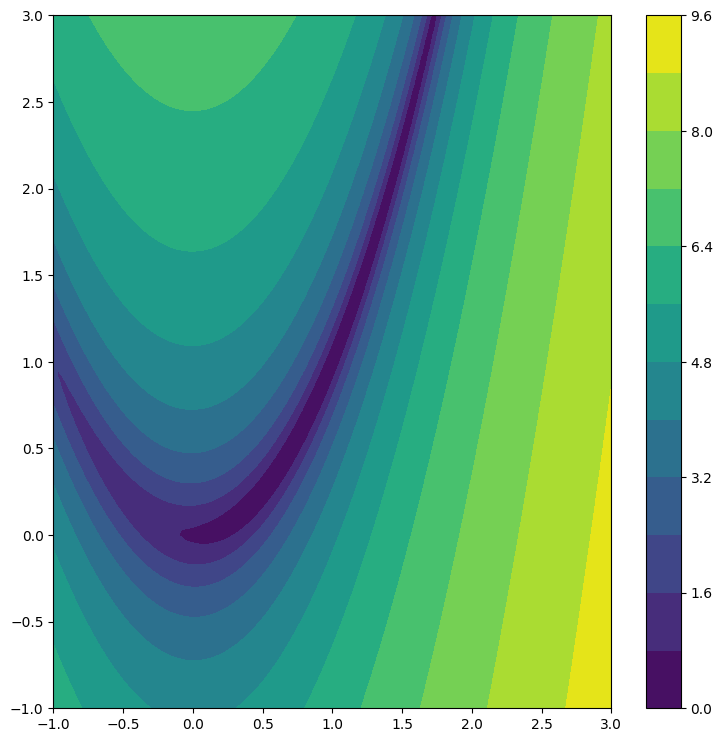

In [4]:
xs, ys = jnp.linspace(*RANGE_X, num=127), jnp.linspace(*RANGE_Y, num=129)
Xs, Ys = jnp.meshgrid(xs, ys, indexing='ij')

Fs = target(Point(Xs, Ys))

plt.figure(figsize=(9, 9))
plt.contourf(xs, ys, jnp.log1p(Fs.T), levels=11)
plt.colorbar()

In [9]:
BATCH = 2

BATCH_PROPOSAL = 2

rng_proposal = jax.random.PRNGKey(2222999)


optimizers = dict(
    lrs=crayopt.LRS(learning_rate=1e-2),
    mrs=crayopt.MRS(learning_rate=1e-2),
    dmrs=crayopt.DMRS(learning_rate=1e-2, rho=0.9),
    linmrs=crayopt.LinMRS(learning_rate=1e-2, rho=0.9),
    rss=crayopt.RSS(learning_rate=1e-2, rho=0.9),
    uadam=crayopt.uadam(learning_rate=1e-2),
#     linlax=crayopt.LinLAX(
#         sigma=1e-2,
#         gradient=crayopt.adamax(learning_rate=1e-2, beta1=0.9, beta2=0.95)
#     ),
#     quadlax=crayopt.QuadLAX(
#         sigma=1e-2,
#         gradient=crayopt.adamax(learning_rate=1e-2, beta1=0.9, beta2=0.95)
#     ),
    fastlinlax=crayopt.FastLinLAX(
        sigma=1e-3,
        gradient=crayopt.adamax(learning_rate=1e-2, beta1=0.9, beta2=0.95)
    ),
    fastquadlax=crayopt.FastQuadLAX(
        sigma=1e-3,
        gradient=crayopt.adamax(learning_rate=1e-2, beta1=0.9, beta2=0.95)
    ),
    lingrad=crayopt.LinGrad(
        sigma=1e-3,
        gradient=crayopt.adamax(learning_rate=1e-2, beta1=0.9, beta2=0.95)
    ),
#     ses=crayopt.SES(
#         initial_sigma=1e-2,
#         gradient=crayopt.adamax(learning_rate=1e-1, beta1=0.9, beta2=0.95)
#     ),
#     reinforce=crayopt.REINFORCE(sigma=1e-2, gradient=crayopt.adamax(learning_rate=2e-2, beta1=0.9, beta2=0.95))
)

def get_step(optimizer):
    def step(rng, state):
        proposal = optimizer.propose(rng, state, batch=(BATCH, ))
        track_proposal = optimizer.propose(rng_proposal, state, batch=(BATCH_PROPOSAL, ))
        value = target(proposal)
        return proposal, *optimizer(proposal, value, state)

    return step

steps = {
    name: jax.jit(get_step(opt))
    for name, opt in optimizers.items()
}

In [10]:
n_trials = 8
n = 1024

trial_rng = jax.random.PRNGKey(122222)
trial_rng, key_x0, key_y0 = jax.random.split(trial_rng, num=3)


initial_ps = Point(
    x=jax.random.uniform(key_x0, shape=(n_trials,), dtype=jnp.float32) * (RANGE_X[1] - RANGE_X[0]) + RANGE_X[0],
    y=jax.random.uniform(key_y0, shape=(n_trials,), dtype=jnp.float32) * (RANGE_Y[1] - RANGE_Y[0]) + RANGE_Y[0],
)

traces = {
    name: np.zeros(shape=(n_trials, n, 2))
    for name in optimizers
}

proposals = {
    name: np.zeros(shape=(n, BATCH, 2))
    for name in optimizers
}

states = {
    name: list()
    for name in optimizers
}

for name, step in steps.items():
    rng = trial_rng

    for i in tqdm(range(n_trials), desc=name):
        state = optimizers[name].initial_state(
            Point(initial_ps.x[i], initial_ps.y[i])
        )
    
        for j in range(n):
            rng, key = jax.random.split(rng, num=2)
            proposal, traces[name][i, j], state = step(key, state)
            
            if i == 0:
                states[name].append(state)
                proposals[name][j, :, 0] = proposal.x
                proposals[name][j, :, 1] = proposal.y

lrs:   0%|          | 0/8 [00:00<?, ?it/s]

mrs:   0%|          | 0/8 [00:00<?, ?it/s]

dmrs:   0%|          | 0/8 [00:00<?, ?it/s]

linmrs:   0%|          | 0/8 [00:00<?, ?it/s]

rss:   0%|          | 0/8 [00:00<?, ?it/s]

uadam:   0%|          | 0/8 [00:00<?, ?it/s]

fastlinlax:   0%|          | 0/8 [00:00<?, ?it/s]

fastquadlax:   0%|          | 0/8 [00:00<?, ?it/s]

lingrad:   0%|          | 0/8 [00:00<?, ?it/s]

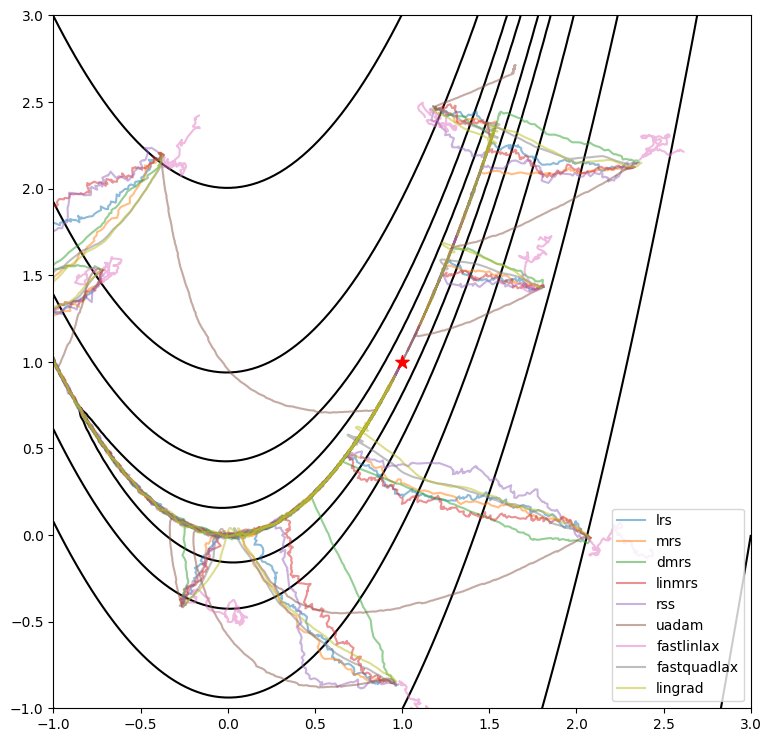

In [11]:
xs, ys = jnp.linspace(*RANGE_X, num=127), jnp.linspace(*RANGE_Y, num=129)
Xs, Ys = jnp.meshgrid(xs, ys, indexing='ij')

Fs = target(Point(Xs, Ys))

plt.figure(figsize=(9, 9))
plt.contour(xs, ys, jnp.log1p(Fs.T), colors='black', levels=7)
plt.scatter([1], [1], marker='*', color='red', s=100, zorder=100)

for i, (name, trace) in enumerate(traces.items()):
    plt.plot(trace[0, :, 0], trace[0, :, 1].T, alpha=0.5, color=plt.cm.tab10(i), label=name)
    plt.plot(trace[1:, :, 0].T, trace[1:, :, 1].T, alpha=0.5, color=plt.cm.tab10(i))

    
plt.xlim(RANGE_X)
plt.ylim(RANGE_Y)
plt.legend(loc='lower right')

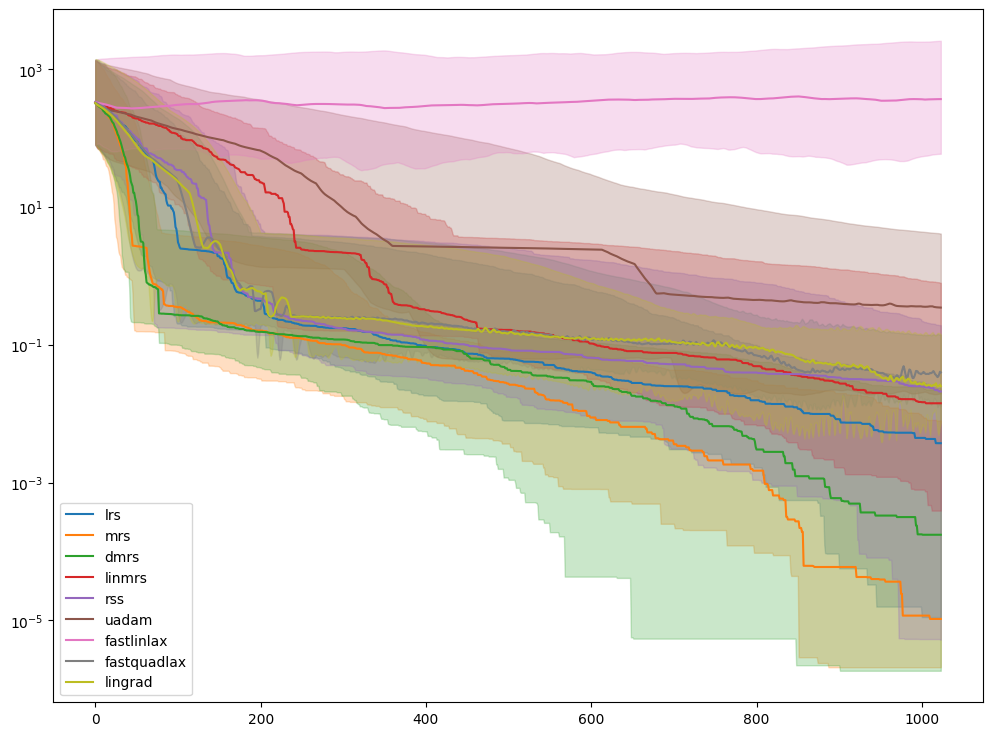

In [12]:
plt.figure(figsize=(12, 9))

for i, (name, trace) in enumerate(traces.items()):
    ys = target(Point(trace[..., 0], trace[..., 1]))
    ys_median = np.median(ys, axis=0)
    ys_lower = np.quantile(ys, q=0.1, axis=0)
    ys_upper = np.quantile(ys, q=0.9, axis=0)
    xs = np.arange(n)
    
    plt.plot(xs, ys_median, color=plt.cm.tab10(i), label=name)
    plt.fill_between(xs, ys_lower, ys_upper, alpha=0.25, color=plt.cm.tab10(i), )

plt.legend()
plt.yscale('log')

In [13]:
n = 32
b = np.random.normal(size=())
w = np.random.normal(size=(2, ))
mu = np.array([1.0, 1.0])
eps = np.random.normal(size=(n, 2))
sigma = 1e-2
xs = sigma * eps  + mu

ys = np.sum(xs * w, axis=-1) + b

In [14]:
print(w, b)
print()
print(*crayopt.LinLAX(sigma=sigma).fit(xs, ys, mu=mu))
print(*crayopt.FastLinLAX(sigma=sigma).fit(xs, ys, mu=mu))
print()
print(*crayopt.QuadLAX(sigma=sigma).fit(xs, ys, mu=mu))
print(*crayopt.FastQuadLAX(sigma=sigma).fit(xs, ys, mu=mu))

[ 0.78743385 -0.40728034] -1.9460061012355052

[ 0.7874344  -0.40728098] -1.9460061
[ 0.7315659 -0.7287515] -1.5692697

[-1.7279997e-05 -4.6698278e-05] [ 0.78746897 -0.4071872 ] -1.9460704
[-1.7279997e-05 -4.6698278e-05] [ 0.78746897 -0.4071872 ] -1.9460704


In [15]:
lax = crayopt.LinLAX(sigma=sigma)
fastlax = crayopt.FastLinLAX(sigma=sigma)

In [16]:
1.58506097 / n

0.0495331553125

In [17]:
_, wlax = lax.value_and_grad_c(eps, mu, lax.fit(xs, ys, mu))
_, wfast = fastlax.value_and_grad_c(eps, mu, fastlax.fit(xs, ys, mu))

print(w)
print(wlax)
print(wfast)

[ 0.78743385 -0.40728034]
[ 0.7874342  -0.40728095]
[ 0.73156565 -0.7287516 ]


In [18]:
wlax = lax.grad_J(xs, ys, mu)
wfast = fastlax.grad_J(xs, ys, mu)

print(w)
print(wlax)
print(wfast)

[ 0.78743385 -0.40728034]
[12.8889     -0.40178514]
[12.8889     -0.40178514]


In [19]:
print(lax.lax_grad(xs, ys, mu)[0])
print(fastlax.lax_grad(xs, ys, mu)[0])
print(w)

[ 0.7874337  -0.40728277]
[ 0.6669629  -0.37062126]
[ 0.78743385 -0.40728034]


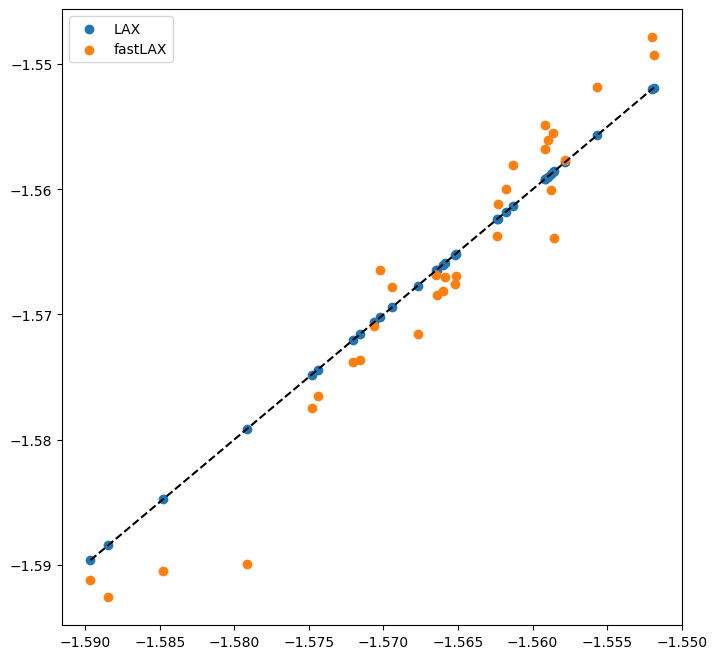

In [20]:
plt.figure(figsize=(8, 8))
plt.scatter(
    ys,
    lax.predict(xs, lax.fit(xs, ys, mu)),
    label='LAX'
)

plt.scatter(
    ys,
    fastlax.predict(xs, fastlax.fit(xs, ys, mu)),
    label='fastLAX'
)

plt.plot([np.min(ys), np.max(ys)], [np.min(ys), np.max(ys)], color='black', linestyle='--')
plt.legend()

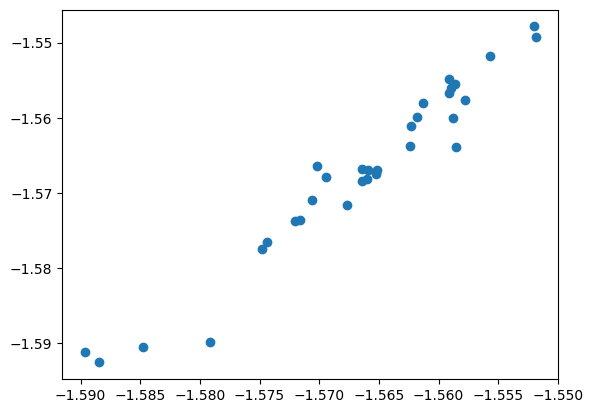

In [21]:
plt.scatter(
    ys,
    lax.predict(xs, fastlax.fit(xs, ys, mu))
)